# Beta-diversity vs breeding history with corMLPE

Test hypotheses on release year vs MCC
Test hypothesis on mergeddataset

In [1]:
%load_ext rpy2.ipython

In [4]:
%%R
library(foreach)
library(Hmisc)
library(lme4)
library(lmerTest)
library(ggplot2)
library(plyr)
library(dplyr)
library(tidyr)
library(pbkrtest)
library(gridExtra)
library(reshape2)
library(doParallel)
library(phyloseq)
library(MuMIn)


In [5]:
%%R
# Initialize corMLPE 
source('/home/bryan/corMLPE/corMLPE.R')

In [6]:
%%R
# set theme for ggplot

theme_pub = function (base_size = 11, base_family = "Helvetica") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE)
    }


# Set up tables

## Loading phyloseq object

In [7]:
%%R
setwd('/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/')

In [8]:
%%R 
# loading

physeq = readRDS('ERA_snorm.rds')

#remove T0, not necessary
physeq = subset_samples(physeq, !is.na(Genotype), TRUE)
physeq = transform_sample_counts(physeq, sqrt)
physeq = subset_samples(physeq, 
            SeedTreatment == "Treated" & Genotype != "Bare" & 
                        TimePoint != "T0" & Fert == "85") # see seed treatment notebook for comparison


physeq = filter_taxa(physeq, function(x) sum(x > 0) > 0, TRUE)  
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 96 samples ]
sample_data() Sample Data:       [ 96 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [9]:
%%R
# add interaction of genotype and sampling date term for merge
sd = sample_data(physeq)
sd = mutate(sd, TxG = paste(TimePoint, R_Year, sep = "_"))
rownames(sd) = sd$X.sampleID
sample_data(physeq) = sd


In [10]:
%%R
# save TxG, R_Year and Sampling date lookup table

Y.df = sd %>%
    select(TxG, R_Year, TimePoint) %>%
    unique
colnames(Y.df) = c("Sample", "R_Year", "TimePoint")
head(Y.df)


                Sample R_Year TimePoint
ERA-T2_3-1d_85 T2_2001   2001        T2
ERA-T1_2-2b_85 T1_1971   1971        T1
ERA-T1_1-2d_85 T1_2011   2011        T1
ERA-T2_1-2b_85 T2_1939   1939        T2
ERA-T3_2-2b_85 T3_1971   1971        T3
ERA-T2_1-2d_85 T2_2011   2011        T2


In [11]:
%%R
dim(Y.df)

[1] 24  3


In [12]:
%%R
m.phy = merge_samples(physeq, "TxG")  %>%

    transform_sample_counts(function(x) x/sum(x))
        
m.phy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 24 samples ]
sample_data() Sample Data:       [ 24 samples by 47 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [13]:
%%R
registerDoParallel(cores=28)
bray.dist = distance(m.phy, 
                      method = "bray", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


# Data wrangling 

### Melt unifrac distances

In [14]:
%%R
bd = as.matrix(bray.dist) 
# remove lower triangle to remove duplicate values
bd[ lower.tri( bd, diag = TRUE ) ]  <- NA
head(bd)
bd.m = melt(bd, na.rm= TRUE)

# rename columns
colnames(bd.m) = c("SampleA", "SampleB", "bray_Dist")
head(bd.m) %>% print
dim(bd.m) %>% print

   SampleA SampleB bray_Dist
25 T1_1939 T1_1953 0.1502060
49 T1_1939 T1_1971 0.1617041
50 T1_1953 T1_1971 0.1464197
73 T1_1939 T1_1984 0.1498719
74 T1_1953 T1_1984 0.1401895
75 T1_1971 T1_1984 0.1467838
[1] 276   3


In [15]:
%%R

## add Year of plant A and plant b
Dist= inner_join(bd.m, Y.df, by = c("SampleA" = "Sample"))
colnames(Dist)[4:5] = c("YearA", "TimePointA")

Dist= inner_join(Dist, Y.df, by = c("SampleB" = "Sample"))
colnames(Dist)[6:7] = c("YearB", "TimePointB")

Dist = mutate(Dist, YearDist = abs(YearA - YearB))
head(Dist)

  SampleA SampleB bray_Dist YearA TimePointA YearB TimePointB YearDist
1 T1_1939 T1_1953 0.1502060  1939         T1  1953         T1       14
2 T1_1939 T1_1971 0.1617041  1939         T1  1971         T1       32
3 T1_1953 T1_1971 0.1464197  1953         T1  1971         T1       18
4 T1_1939 T1_1984 0.1498719  1939         T1  1984         T1       45
5 T1_1953 T1_1984 0.1401895  1953         T1  1984         T1       31
6 T1_1971 T1_1984 0.1467838  1971         T1  1984         T1       13


In [16]:
%%R
#Filter so that we are not comparing across timepoints
Dist = Dist %>% filter(TimePointA == TimePointB)
head(Dist) %>% print
tail(Dist) %>% print

  SampleA SampleB bray_Dist YearA TimePointA YearB TimePointB YearDist
1 T1_1939 T1_1953 0.1502060  1939         T1  1953         T1       14
2 T1_1939 T1_1971 0.1617041  1939         T1  1971         T1       32
3 T1_1953 T1_1971 0.1464197  1953         T1  1971         T1       18
4 T1_1939 T1_1984 0.1498719  1939         T1  1984         T1       45
5 T1_1953 T1_1984 0.1401895  1953         T1  1984         T1       31
6 T1_1971 T1_1984 0.1467838  1971         T1  1984         T1       13
   SampleA SampleB bray_Dist YearA TimePointA YearB TimePointB YearDist
91 T3_1984 T3_2001 0.1579147  1984         T3  2001         T3       17
92 T3_1939 T3_2011 0.1451982  1939         T3  2011         T3       72
93 T3_1953 T3_2011 0.1728111  1953         T3  2011         T3       58
94 T3_1971 T3_2011 0.1613908  1971         T3  2011         T3       40
95 T3_1984 T3_2011 0.1459290  1984         T3  2011         T3       27
96 T3_2001 T3_2011 0.1678215  2001         T3  2011         T3       10

# Build corMLPE models

## Null model:
fit null model with random effect of sampling date to stratify covariance matrices

In [17]:
%%R
fitNull =  lme(bray_Dist ~ 1, random = ~1|TimePointB,
               correlation = corMLPE(form= ~ SampleA + SampleB), data = Dist, method = "ML")


In [18]:
%%R
summary(fitNull)

Linear mixed-effects model fit by maximum likelihood
 Data: Dist 
        AIC       BIC   logLik
  -606.3557 -596.0983 307.1778

Random effects:
 Formula: ~1 | TimePointB
        (Intercept)   Residual
StdDev: 5.39897e-07 0.01169587

Correlation Structure: corMLPE
 Formula: ~SampleA + SampleB | TimePointB 
 Parameter estimate(s):
     Rho 
0.261856 
Fixed effects: bray_Dist ~ 1 
                Value   Std.Error DF  t-value p-value
(Intercept) 0.1550776 0.002611093 93 59.39183       0

Standardized Within-Group Residuals:
        Min          Q1         Med          Q3         Max 
-2.03525270 -0.76394115  0.03990495  0.54072403  2.64917275 

Number of Observations: 96
Number of Groups: 3 


In [19]:
%%R
fit1 =  lme(bray_Dist ~ poly(YearDist,2),, random = ~1|TimePointB,
               correlation = corMLPE(form= ~ SampleA + SampleB), data = Dist, method = "ML")

summary(fit1)

Linear mixed-effects model fit by maximum likelihood
 Data: Dist 
        AIC       BIC   logLik
  -612.4368 -597.0507 312.2184

Random effects:
 Formula: ~1 | TimePointB
         (Intercept)   Residual
StdDev: 6.063255e-07 0.01176677

Correlation Structure: corMLPE
 Formula: ~SampleA + SampleB | TimePointB 
 Parameter estimate(s):
      Rho 
0.3015836 
Fixed effects: bray_Dist ~ poly(YearDist, 2) 
                         Value   Std.Error DF  t-value p-value
(Intercept)         0.15500389 0.002804268 91 55.27428  0.0000
poly(YearDist, 2)1 -0.00257953 0.008683139 91 -0.29707  0.7671
poly(YearDist, 2)2 -0.02810090 0.008592712 91 -3.27032  0.0015
 Correlation: 
                   (Intr) p(YD,2)1
poly(YearDist, 2)1 -0.006         
poly(YearDist, 2)2  0.008  0.227  

Standardized Within-Group Residuals:
        Min          Q1         Med          Q3         Max 
-2.17452054 -0.72908519  0.02476341  0.62491681  2.39308934 

Number of Observations: 96
Number of Groups: 3 


In [20]:
%%R
MuMIn::r.squaredLR(fit1, null = fitNull)

[1] 0.09968625
attr(,"adj.r.squared")
[1] -0.0001659869


In [21]:
%%R
anova(fitNull, fit1)

        Model df       AIC       BIC   logLik   Test  L.Ratio p-value
fitNull     1  4 -606.3557 -596.0983 307.1778                        
fit1        2  6 -612.4368 -597.0507 312.2184 1 vs 2 10.08115  0.0065


In [22]:
%%R
fit1.b =  lme(bray_Dist ~ I(YearDist) + I(YearDist^2), random = ~1|TimePointB,
               correlation = corMLPE(form= ~ SampleA + SampleB), data = Dist, method = "ML")

summary(fit1.b)

Linear mixed-effects model fit by maximum likelihood
 Data: Dist 
        AIC       BIC   logLik
  -612.4368 -597.0507 312.2184

Random effects:
 Formula: ~1 | TimePointB
         (Intercept)   Residual
StdDev: 6.063217e-07 0.01176677

Correlation Structure: corMLPE
 Formula: ~SampleA + SampleB | TimePointB 
 Parameter estimate(s):
      Rho 
0.3015836 
Fixed effects: bray_Dist ~ I(YearDist) + I(YearDist^2) 
                    Value   Std.Error DF  t-value p-value
(Intercept)    0.14817309 0.003692601 91 40.12703  0.0000
I(YearDist)    0.00055020 0.000167980 91  3.27540  0.0015
I(YearDist^2) -0.00000769 0.000002352 91 -3.27032  0.0015
 Correlation: 
              (Intr) I(YrD)
I(YearDist)   -0.603       
I(YearDist^2)  0.517 -0.965

Standardized Within-Group Residuals:
        Min          Q1         Med          Q3         Max 
-2.17452054 -0.72908519  0.02476341  0.62491681  2.39308933 

Number of Observations: 96
Number of Groups: 3 


* Year of release as a polynomial function explains  14% of the variation!

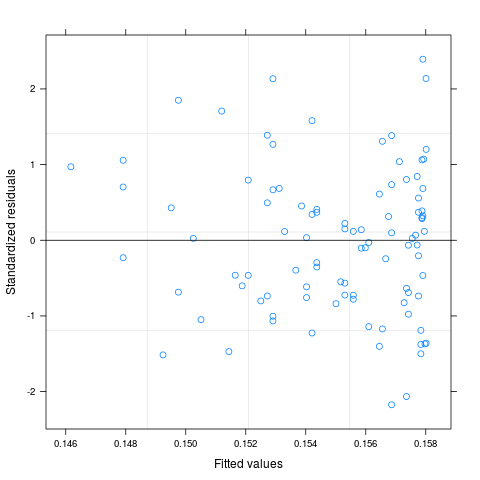

In [23]:
%%R
plot(fit1.b)

In [24]:
%%R
MuMIn::r.squaredLR(fit1.b, null = fitNull)

[1] 0.09968625
attr(,"adj.r.squared")
[1] -0.0001659869


## Graphs

### phylogenetic distance vs microbial community

In [25]:
%%R
coef(fit1.b)

   (Intercept)  I(YearDist) I(YearDist^2)
T1   0.1481731 0.0005502038 -7.691941e-06
T2   0.1481731 0.0005502038 -7.691941e-06
T3   0.1481731 0.0005502038 -7.691941e-06


In [26]:
%%R
fit1.ci = intervals(fit1.b, which = "fixed")
fit1.ci

Approximate 95% confidence intervals

 Fixed effects:
                      lower          est.         upper
(Intercept)    1.409537e-01  1.481731e-01  1.553925e-01
I(YearDist)    2.217863e-04  5.502038e-04  8.786212e-04
I(YearDist^2) -1.229041e-05 -7.691941e-06 -3.093469e-06
attr(,"label")
[1] "Fixed effects:"


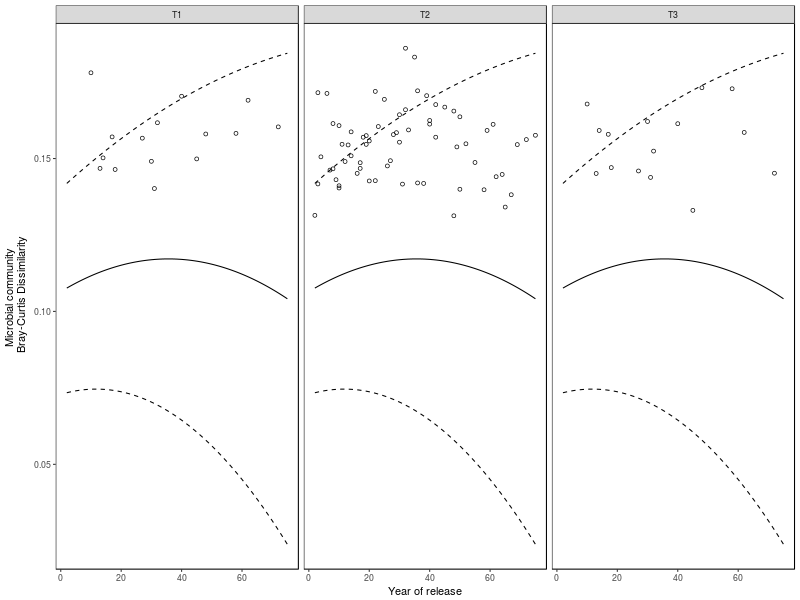

In [27]:
%%R -w 800 -h 600


model1 <- function(x) {-8.421231e-06*x ^ 2 + 6.004655e-04*x + 1.064713e-01}
model1.CImin <- function(x) {-1.266309e-05*x ^ 2 + 2.961556e-04*x + 7.286897e-02}
model1.CImax <- function(x) {-4.179372e-06*x ^ 2 + 9.047755e-04*x + 1.400736e-01}

p = ggplot(Dist, aes(y = bray_Dist, x = YearDist)) 
p = p + geom_point(pch = 21) #aes(size = phy_Dist), shape = 1)
#p = p + stat_smooth(method = "lm", se = FALSE)
p = p + theme_pub()
#p = p + theme(panel.border = element_blank()) 
#p = p + theme(axis.line.x = element_line(color="black", size = 1),
 #   axis.line.y = element_line(color="black", size = 1))

p = p + stat_function(fun = model1)
p = p + stat_function(fun = model1.CImin, linetype = "dashed")
p = p + stat_function(fun = model1.CImax, linetype = "dashed")

p = p + labs(x = "Year of release")
p = p + labs(y = "Microbial community \n Bray-Curtis Dissimilarity") 
p = p + facet_wrap(~TimePointB)

p


* One curve does not fit the three time points well.  Better to seperate:

## Split calculate by time point separately 

### T1:


In [114]:
%%R
Dist.T1 = filter(Dist, TimePointB == "T1")
dim(Dist.T1)

[1] 15  8


In [115]:
%%R
T1Null =  gls(bray_Dist ~ 1, 
               correlation = corMLPE(form= ~ SampleA + SampleB), data = Dist.T1, method = "ML")


In [116]:
%%R
summary(T1Null)

Generalized least squares fit by maximum likelihood
  Model: bray_Dist ~ 1 
  Data: Dist.T1 
        AIC      BIC   logLik
  -94.09105 -91.9669 50.04552

Correlation Structure: corMLPE
 Formula: ~SampleA + SampleB 
 Parameter estimate(s):
      Rho 
0.3335016 

Coefficients:
                Value   Std.Error  t-value p-value
(Intercept) 0.1568028 0.005387809 29.10327       0

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-1.57832593 -0.69578593  0.02541646  0.40121252  2.01704899 

Residual standard error: 0.01052594 
Degrees of freedom: 15 total; 14 residual


In [117]:
%%R
T1fit1 =  gls(bray_Dist ~ YearDist, 
               correlation = corMLPE(form= ~ SampleA + SampleB), data = Dist.T1, method = "ML")


In [118]:
%%R
summary(T1fit1)

Generalized least squares fit by maximum likelihood
  Model: bray_Dist ~ YearDist 
  Data: Dist.T1 
        AIC       BIC   logLik
  -92.14564 -89.31344 50.07282

Correlation Structure: corMLPE
 Formula: ~SampleA + SampleB 
 Parameter estimate(s):
      Rho 
0.3432679 

Coefficients:
                  Value   Std.Error   t-value p-value
(Intercept)  0.15765201 0.006772761 23.277364  0.0000
YearDist    -0.00002464 0.000104843 -0.234992  0.8179

 Correlation: 
         (Intr)
YearDist -0.534

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-1.56490018 -0.69946999 -0.01525646  0.43624680  1.93317272 

Residual standard error: 0.01067082 
Degrees of freedom: 15 total; 13 residual


In [119]:
%%R
MuMIn::r.squaredLR(T1fit1, null = T1Null)

[1] 0.003632807
attr(,"adj.r.squared")
[1] -4.601076e-06


In [120]:
%%R
anova(T1fit1, T1Null)

       Model df       AIC       BIC   logLik   Test    L.Ratio p-value
T1fit1     1  4 -92.14564 -89.31344 50.07282                          
T1Null     2  3 -94.09105 -91.96690 50.04552 1 vs 2 0.05459133  0.8153


### T3:


In [36]:
%%R
Dist.T3 = filter(Dist, TimePointB == "T3")
dim(Dist.T3)

[1] 15  8


In [37]:
%%R
T3Null =  gls(bray_Dist ~ 1, 
               correlation = corMLPE(form= ~ SampleA + SampleB), data = Dist.T3, method = "ML")


In [38]:
%%R
summary(T3Null)

Generalized least squares fit by maximum likelihood
  Model: bray_Dist ~ 1 
  Data: Dist.T3 
        AIC       BIC   logLik
  -90.40231 -88.27816 48.20116

Correlation Structure: corMLPE
 Formula: ~SampleA + SampleB 
 Parameter estimate(s):
      Rho 
0.3388424 

Coefficients:
                Value   Std.Error  t-value p-value
(Intercept) 0.1550324 0.006179377 25.08869       0

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.8313015 -0.7888986  0.2401311  0.5598540  1.5090433 

Residual standard error: 0.01200269 
Degrees of freedom: 15 total; 14 residual


In [39]:
%%R
T3fit1 =  gls(bray_Dist ~ YearDist, 
               correlation = corMLPE(form= ~ SampleA + SampleB), data = Dist.T3, method = "ML")


In [40]:
%%R
summary(T3fit1)

Generalized least squares fit by maximum likelihood
  Model: bray_Dist ~ YearDist 
  Data: Dist.T3 
       AIC      BIC   logLik
  -88.4197 -85.5875 48.20985

Correlation Structure: corMLPE
 Formula: ~SampleA + SampleB 
 Parameter estimate(s):
      Rho 
0.3405039 

Coefficients:
                  Value   Std.Error   t-value p-value
(Intercept)  0.15554038 0.007634964 20.372116  0.0000
YearDist    -0.00001474 0.000119102 -0.123731  0.9034

 Correlation: 
         (Intr)
YearDist -0.538

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.8145900 -0.7688399  0.2182315  0.5593439  1.5224886 

Residual standard error: 0.01202768 
Degrees of freedom: 15 total; 13 residual


* save Dist df with different name before proceeding

In [41]:
%%R
OrigDist = Dist

## T3 Just fertilized

In [42]:
%%R 
# loading

physeq = readRDS('ERA_snorm.rds')

#remove T0, not necessary
physeq = subset_samples(physeq, !is.na(Genotype), TRUE)
physeq = transform_sample_counts(physeq, sqrt)
physeq = subset_samples(physeq, SeedTreatment == "Treated" & Genotype != "Bare" & TimePoint != "T0") # see seed treatment notebook for comparison

physeq = subset_samples(physeq, Fert == "170")
physeq = filter_taxa(physeq, function(x) sum(x > 0) > 0, TRUE)  
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 48 samples ]
sample_data() Sample Data:       [ 48 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [43]:
%%R
# add interaction of genotype and sampling date term for merge
sd = sample_data(physeq)
sd = mutate(sd, TxG = paste(TimePoint, R_Year, sep = "_"))
rownames(sd) = sd$X.sampleID
sample_data(physeq) = sd


In [44]:
%%R
# save TxG, R_Year and Sampling date lookup table


Y.df = sd %>%
    select(TxG, R_Year, TimePoint) %>%
    unique
colnames(Y.df) = c("Sample", "R_Year", "TimePoint")
head(Y.df)


                 Sample R_Year TimePoint
ERA-T1_3-5c_170 T1_1939   1939        T1
ERA-T1_1-4a_170 T1_1953   1953        T1
ERA-T3_1-3c_170 T3_1971   1971        T3
ERA-T1_4-4a_170 T1_1984   1984        T1
ERA-T1_1-2d_170 T1_2011   2011        T1
ERA-T3_3-4c_170 T3_2011   2011        T3


In [45]:
%%R
dim(Y.df)


[1] 12  3


In [46]:
%%R
m.phy = merge_samples(physeq, "TxG")  %>%

    transform_sample_counts(function(x) x/sum(x))
   

In [47]:
%%R
registerDoParallel(cores=28)
bray.dist = distance(m.phy, 
                      method = "bray", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


# Data wrangling 

### Melt unifrac distances

In [48]:
%%R
bd = as.matrix(bray.dist) 
# remove lower triangle to remove duplicate values
bd[ lower.tri( bd, diag = TRUE ) ]  <- NA
head(bd)
bd.m = melt(bd, na.rm= TRUE)

# rename columns
colnames(bd.m) = c("SampleA", "SampleB", "bray_Dist")
head(bd.m) %>% print
dim(bd.m) %>% print

   SampleA SampleB bray_Dist
13 T1_1939 T1_1953 0.1266649
25 T1_1939 T1_1971 0.1453595
26 T1_1953 T1_1971 0.1516510
37 T1_1939 T1_1984 0.1328425
38 T1_1953 T1_1984 0.1380945
39 T1_1971 T1_1984 0.1467351
[1] 66  3


In [50]:
%%R

## add Year of plant A and plant b
Dist= inner_join(bd.m, Y.df, by = c("SampleA" = "Sample"))
colnames(Dist)[4:5] = c("YearA", "TimePointA")

Dist= inner_join(Dist, Y.df, by = c("SampleB" = "Sample"))
colnames(Dist)[6:7] = c("YearB", "TimePointB")

Dist = mutate(Dist, YearDist = abs(YearA - YearB))
head(Dist)

  SampleA SampleB bray_Dist YearA TimePointA YearB TimePointB YearDist
1 T1_1939 T1_1953 0.1266649  1939         T1  1953         T1       14
2 T1_1939 T1_1971 0.1453595  1939         T1  1971         T1       32
3 T1_1953 T1_1971 0.1516510  1953         T1  1971         T1       18
4 T1_1939 T1_1984 0.1328425  1939         T1  1984         T1       45
5 T1_1953 T1_1984 0.1380945  1953         T1  1984         T1       31
6 T1_1971 T1_1984 0.1467351  1971         T1  1984         T1       13


In [51]:
%%R
#Filter so that we are not comparing across timepoints
Dist = Dist %>% filter(TimePointA == TimePointB)
head(Dist) %>% print
tail(Dist) %>% print

  SampleA SampleB bray_Dist YearA TimePointA YearB TimePointB YearDist
1 T1_1939 T1_1953 0.1266649  1939         T1  1953         T1       14
2 T1_1939 T1_1971 0.1453595  1939         T1  1971         T1       32
3 T1_1953 T1_1971 0.1516510  1953         T1  1971         T1       18
4 T1_1939 T1_1984 0.1328425  1939         T1  1984         T1       45
5 T1_1953 T1_1984 0.1380945  1953         T1  1984         T1       31
6 T1_1971 T1_1984 0.1467351  1971         T1  1984         T1       13
   SampleA SampleB bray_Dist YearA TimePointA YearB TimePointB YearDist
25 T3_1984 T3_2001 0.1543720  1984         T3  2001         T3       17
26 T3_1939 T3_2011 0.1519520  1939         T3  2011         T3       72
27 T3_1953 T3_2011 0.1760184  1953         T3  2011         T3       58
28 T3_1971 T3_2011 0.1508612  1971         T3  2011         T3       40
29 T3_1984 T3_2011 0.1559243  1984         T3  2011         T3       27
30 T3_2001 T3_2011 0.1564101  2001         T3  2011         T3       10

In [52]:
%%R
Dist.T3 = filter(Dist, TimePointB == "T3")
dim(Dist.T3)

[1] 15  8


In [53]:
%%R
T3Null =  gls(bray_Dist ~ 1, 
               correlation = corMLPE(form= ~ SampleA + SampleB), data = Dist.T3, method = "ML")


In [54]:
%%R
summary(T3Null)

Generalized least squares fit by maximum likelihood
  Model: bray_Dist ~ 1 
  Data: Dist.T3 
        AIC       BIC   logLik
  -91.84706 -89.72291 48.92353

Correlation Structure: corMLPE
 Formula: ~SampleA + SampleB 
 Parameter estimate(s):
      Rho 
0.4011986 

Coefficients:
                Value   Std.Error t-value p-value
(Intercept) 0.1601152 0.007147427 22.4018       0

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.0383978 -0.5334473 -0.3215218  0.3959718  2.3605377 

Residual standard error: 0.01303449 
Degrees of freedom: 15 total; 14 residual


In [55]:
%%R
T3fit1 =  gls(bray_Dist ~ YearDist, 
               correlation = corMLPE(form= ~ SampleA + SampleB), data = Dist.T3, method = "ML")


In [59]:
%%R
summary(T3fit1)

Generalized least squares fit by maximum likelihood
  Model: bray_Dist ~ YearDist 
  Data: Dist.T3 
        AIC       BIC   logLik
  -89.96665 -87.13445 48.98333

Correlation Structure: corMLPE
 Formula: ~SampleA + SampleB 
 Parameter estimate(s):
      Rho 
0.4043308 

Coefficients:
                 Value   Std.Error   t-value p-value
(Intercept) 0.15896470 0.008268752 19.224750  0.0000
YearDist    0.00003338 0.000102513  0.325619  0.7499

 Correlation: 
         (Intr)
YearDist -0.427

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.1034856 -0.5800343 -0.3009215  0.4410957  2.3578287 

Residual standard error: 0.01309854 
Degrees of freedom: 15 total; 13 residual


# Just core plots to compare relationships over time

In [63]:
%%R 
# loading

physeq = readRDS('ERA_snorm.rds')

#remove T0, not necessary
physeq = subset_samples(physeq, !is.na(Genotype), TRUE)
physeq = transform_sample_counts(physeq, sqrt)
physeq = subset_samples(physeq, SeedTreatment == "Treated" & Genotype != "Bare" & TimePoint != "T0") # see seed treatment notebook for comparison

physeq = subset_samples(physeq, Plant %in% c("330", "34M95", "354", "3475", "3517", "P1151HR") & Fert == "85")
physeq = filter_taxa(physeq, function(x) sum(x > 0) > 0, TRUE)  
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4591 taxa and 72 samples ]
sample_data() Sample Data:       [ 72 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4591 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4591 tips and 4590 internal nodes ]


In [64]:
%%R
# add interaction of genotype and sampling date term for merge
sd = sample_data(physeq)
sd = mutate(sd, TxG = paste(TimePoint, R_Year, sep = "_"))
rownames(sd) = sd$X.sampleID
sample_data(physeq) = sd


In [65]:
%%R
# save TxG, R_Year and Sampling date lookup table


Y.df = sd %>%
    select(TxG, R_Year, TimePoint) %>%
    unique
colnames(Y.df) = c("Sample", "R_Year", "TimePoint")
head(Y.df)


                Sample R_Year TimePoint
ERA-T2_3-1d_85 T2_2001   2001        T2
ERA-T1_2-2b_85 T1_1971   1971        T1
ERA-T1_1-2d_85 T1_2011   2011        T1
ERA-T2_1-2b_85 T2_1939   1939        T2
ERA-T3_2-2b_85 T3_1971   1971        T3
ERA-T2_1-2d_85 T2_2011   2011        T2


In [66]:
%%R
m.phy = merge_samples(physeq, "TxG")  %>%

    transform_sample_counts(function(x) x/sum(x))
   

In [67]:
%%R
registerDoParallel(cores=28)
bray.dist = distance(m.phy, 
                      method = "bray", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


# Data wrangling 

### Melt unifrac distances

In [68]:
%%R
bd = as.matrix(bray.dist) 
# remove lower triangle to remove duplicate values
bd[ lower.tri( bd, diag = TRUE ) ]  <- NA
head(bd)
bd.m = melt(bd, na.rm= TRUE)

# rename columns
colnames(bd.m) = c("SampleA", "SampleB", "bray_Dist")
head(bd.m) %>% print
dim(bd.m) %>% print

   SampleA SampleB bray_Dist
19 T1_1939 T1_1953 0.1502060
37 T1_1939 T1_1971 0.1617041
38 T1_1953 T1_1971 0.1464197
55 T1_1939 T1_1984 0.1498719
56 T1_1953 T1_1984 0.1401895
57 T1_1971 T1_1984 0.1467838
[1] 153   3


In [69]:
%%R

## add Year of plant A and plant b
Dist= inner_join(bd.m, Y.df, by = c("SampleA" = "Sample"))
colnames(Dist)[4:5] = c("YearA", "TimePointA")

Dist= inner_join(Dist, Y.df, by = c("SampleB" = "Sample"))
colnames(Dist)[6:7] = c("YearB", "TimePointB")

Dist = mutate(Dist, YearDist = abs(YearA - YearB))
head(Dist)

  SampleA SampleB bray_Dist YearA TimePointA YearB TimePointB YearDist
1 T1_1939 T1_1953 0.1502060  1939         T1  1953         T1       14
2 T1_1939 T1_1971 0.1617041  1939         T1  1971         T1       32
3 T1_1953 T1_1971 0.1464197  1953         T1  1971         T1       18
4 T1_1939 T1_1984 0.1498719  1939         T1  1984         T1       45
5 T1_1953 T1_1984 0.1401895  1953         T1  1984         T1       31
6 T1_1971 T1_1984 0.1467838  1971         T1  1984         T1       13


In [70]:
%%R
#Filter so that we are not comparing across timepoints
Dist = Dist %>% filter(TimePointA == TimePointB)
head(Dist) %>% print
tail(Dist) %>% print

  SampleA SampleB bray_Dist YearA TimePointA YearB TimePointB YearDist
1 T1_1939 T1_1953 0.1502060  1939         T1  1953         T1       14
2 T1_1939 T1_1971 0.1617041  1939         T1  1971         T1       32
3 T1_1953 T1_1971 0.1464197  1953         T1  1971         T1       18
4 T1_1939 T1_1984 0.1498719  1939         T1  1984         T1       45
5 T1_1953 T1_1984 0.1401895  1953         T1  1984         T1       31
6 T1_1971 T1_1984 0.1467838  1971         T1  1984         T1       13
   SampleA SampleB bray_Dist YearA TimePointA YearB TimePointB YearDist
40 T3_1984 T3_2001 0.1579147  1984         T3  2001         T3       17
41 T3_1939 T3_2011 0.1451982  1939         T3  2011         T3       72
42 T3_1953 T3_2011 0.1728111  1953         T3  2011         T3       58
43 T3_1971 T3_2011 0.1613908  1971         T3  2011         T3       40
44 T3_1984 T3_2011 0.1459290  1984         T3  2011         T3       27
45 T3_2001 T3_2011 0.1678215  2001         T3  2011         T3       10

In [71]:
%%R
dim(Dist)

[1] 45  8


In [77]:
%%R
#Separate distance table by timepoint and rejoin with distances between plants at each timepoint in different columns
Dist.T1 = filter(Dist, TimePointA == "T1") 
    colnames(Dist.T1)[3] = "bray_Dist.T1"
Dist.T2 = filter(Dist, TimePointA == "T2")
    colnames(Dist.T2)[3] = "bray_Dist.T2"
Dist.T3 = filter(Dist, TimePointA == "T3")
    colnames(Dist.T3)[3] = "bray_Dist.T3"

Dist.c = left_join(Dist.T1[,c(3,4,6)], Dist.T2[,c(3,4,6)])
Dist.c = left_join(Dist.c, Dist.T3[,c(3,4,6)])
Dist.c 

   bray_Dist.T1 YearA YearB bray_Dist.T2 bray_Dist.T3
1     0.1502060  1939  1953    0.1508864    0.1591749
2     0.1617041  1939  1971    0.1860620    0.1524254
3     0.1464197  1953  1971    0.1569639    0.1470344
4     0.1498719  1939  1984    0.1668123    0.1330519
5     0.1401895  1953  1984    0.1416345    0.1438283
6     0.1467838  1971  1984    0.1544320    0.1451101
7     0.1690555  1939  2001    0.1440525    0.1585380
8     0.1580198  1953  2001    0.1312736    0.1731450
9     0.1490862  1971  2001    0.1643205    0.1621136
10    0.1570704  1984  2001    0.1486369    0.1579147
11    0.1603479  1939  2011    0.1561963    0.1451982
12    0.1582321  1953  2011    0.1397840    0.1728111
13    0.1703658  1971  2011    0.1612489    0.1613908
14    0.1566559  1984  2011    0.1492889    0.1459290
15    0.1780342  2001  2011    0.1403602    0.1678215


* quick and dirty correlations

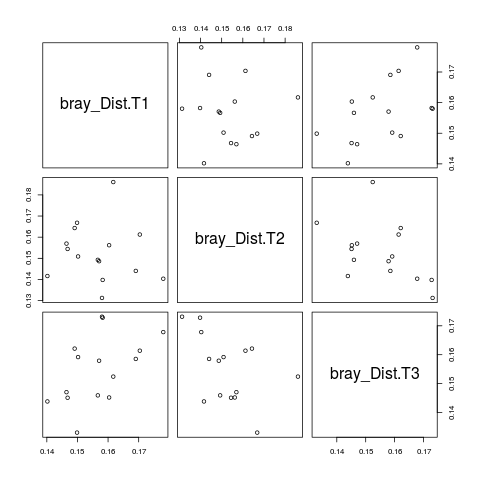

In [78]:
%%R
pairs(Dist.c[,c(1,4,5)])

In [81]:
%%R
T1CompNull =  gls(bray_Dist.T1 ~ 1, 
               correlation = corMLPE(form= ~ YearA + YearB), data = Dist.c, method = "ML")


In [84]:
%%R
T1Comp_2 =  gls(bray_Dist.T1 ~ bray_Dist.T2, 
               correlation = corMLPE(form= ~ YearA + YearB), data = Dist.c, method = "ML")
summary(T1Comp_2)

Generalized least squares fit by maximum likelihood
  Model: bray_Dist.T1 ~ bray_Dist.T2 
  Data: Dist.c 
        AIC       BIC   logLik
  -92.29533 -89.46313 50.14767

Correlation Structure: corMLPE
 Formula: ~YearA + YearB 
 Parameter estimate(s):
      Rho 
0.3360807 

Coefficients:
                   Value  Std.Error   t-value p-value
(Intercept)   0.17113742 0.03435881  4.980889  0.0003
bray_Dist.T2 -0.09381458 0.22186881 -0.422838  0.6793

 Correlation: 
             (Intr)
bray_Dist.T2 -0.987

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-1.68256382 -0.63888251 -0.04535565  0.56620170  1.91160325 

Residual standard error: 0.01049621 
Degrees of freedom: 15 total; 13 residual


In [86]:
%%R
T1Comp_3 =  gls(bray_Dist.T1 ~ bray_Dist.T3, 
               correlation = corMLPE(form= ~ YearA + YearB), data = Dist.c, method = "ML")
summary(T1Comp_3)

Generalized least squares fit by maximum likelihood
  Model: bray_Dist.T1 ~ bray_Dist.T3 
  Data: Dist.c 
       AIC      BIC  logLik
  -95.5238 -92.6916 51.7619

Correlation Structure: corMLPE
 Formula: ~YearA + YearB 
 Parameter estimate(s):
      Rho 
0.3050265 

Coefficients:
                 Value  Std.Error  t-value p-value
(Intercept)  0.0943410 0.03412343 2.764699  0.0161
bray_Dist.T3 0.4028951 0.21805843 1.847648  0.0875

 Correlation: 
             (Intr)
bray_Dist.T3 -0.991

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-1.34065494 -0.73359653 -0.09902626  0.74565281  1.78159676 

Residual standard error: 0.009024874 
Degrees of freedom: 15 total; 13 residual


In [88]:
%%R
MuMIn::r.squaredLR(T1Comp_3, null = T1CompNull)

[1] 0.2045523
attr(,"adj.r.squared")
[1] -0.0002590726


In [87]:
%%R
T2Comp_3 =  gls(bray_Dist.T2 ~ bray_Dist.T3, 
               correlation = corMLPE(form= ~ YearA + YearB), data = Dist.c, method = "ML")
summary(T2Comp_3)

Generalized least squares fit by maximum likelihood
  Model: bray_Dist.T2 ~ bray_Dist.T3 
  Data: Dist.c 
        AIC       BIC   logLik
  -86.53434 -83.70214 47.26717

Correlation Structure: corMLPE
 Formula: ~YearA + YearB 
 Parameter estimate(s):
      Rho 
0.3408864 

Coefficients:
                  Value  Std.Error   t-value p-value
(Intercept)   0.1936360 0.04627174  4.184758  0.0011
bray_Dist.T3 -0.2634234 0.29516457 -0.892463  0.3884

 Correlation: 
             (Intr)
bray_Dist.T3 -0.989

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-1.30714545 -0.63010316 -0.07636388  0.40127949  2.54206178 

Residual standard error: 0.01281573 
Degrees of freedom: 15 total; 13 residual


* distance between genotypes is not correlated between sampling dates, except a marginal relationship between distances at T1 and T3

## Cluster dendrograms

In [94]:
%%R
m.phy.1 = subset_samples(m.phy, TimePoint == "1")
m.phy.2 = subset_samples(m.phy, TimePoint == "2")
m.phy.3 = subset_samples(m.phy, TimePoint == "3")

In [103]:
%%R
sample_names(m.phy.1) = sample_data(m.phy.1)$R_Year
sample_names(m.phy.2) = sample_data(m.phy.2)$R_Year
sample_names(m.phy.3) = sample_data(m.phy.3)$R_Year

In [104]:
%%R
registerDoParallel(cores=28)
bray.dist.1 = distance(m.phy.1, 
                      method = "bray", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

bray.dist.2 = distance(m.phy.2, 
                      method = "bray", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

bray.dist.3 = distance(m.phy.3, 
                      method = "bray", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

NULL
NULL
NULL


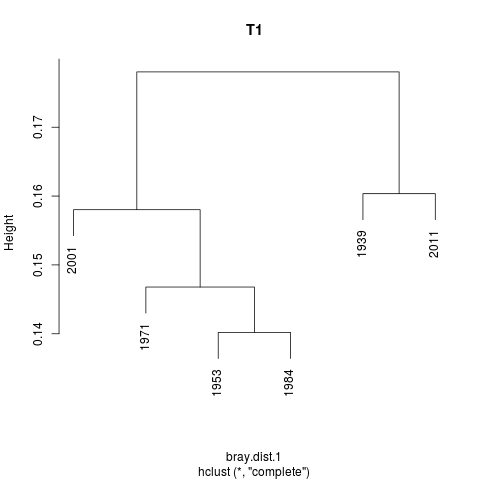

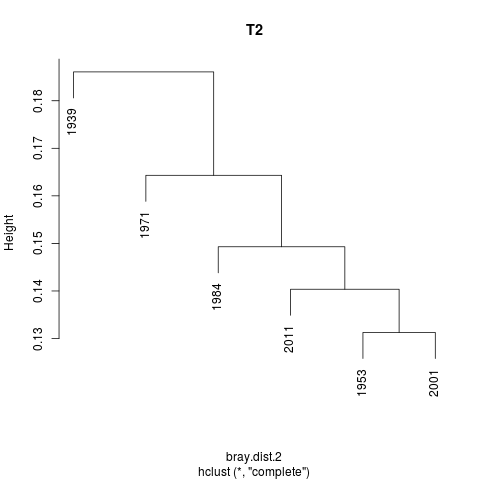

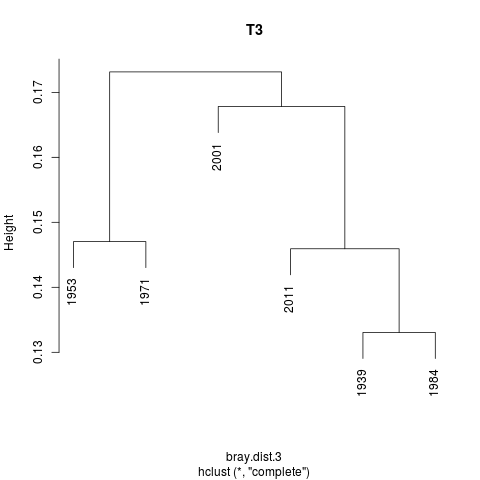

In [113]:
%%R
fit1 <- hclust(bray.dist.1, method="complete") 
plot(fit1, main = "T1")  %>% print

fit2 <- hclust(bray.dist.2, method="complete") 
plot(fit2, main = "T2")  %>% print

fit3 <- hclust(bray.dist.3, method="complete") 
plot(fit3, main = "T3")  %>% print# display dendogram

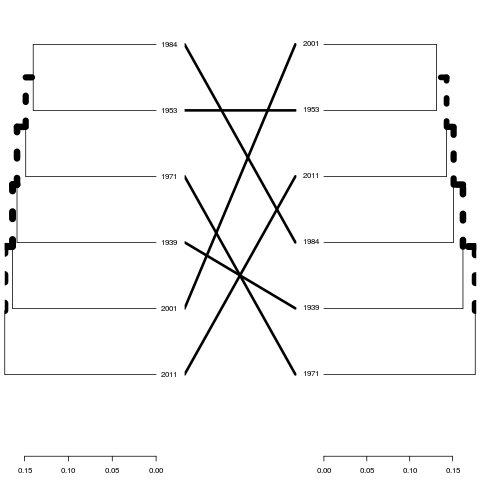

In [111]:
%%R
dendextend::tanglegram(fit1,fit2) 

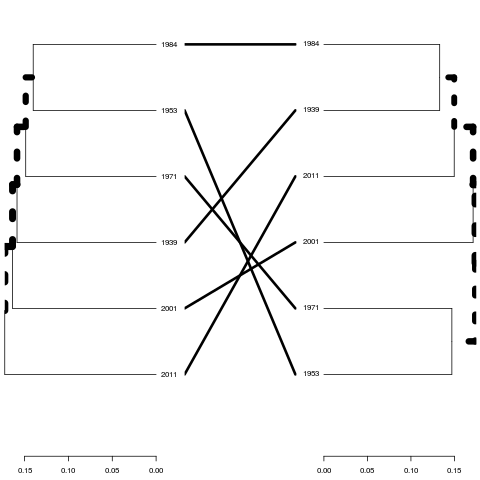

In [112]:
%%R
dendextend::tanglegram(fit1,fit3) 